In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.ndimage import gaussian_filter
import pwlf
from scipy.signal import find_peaks

# colors = ['r', 'k', 'b', 'm', 'g']
colors = ['fuchsia', 'blue', 'green', 'tab:orange', 'tab:red']
linestyles = ['solid', 'dashdot', 'dashed', 'dotted', (0, (3, 5, 1, 5, 1, 5))]
time_slc = slice(6, 8) # last 5ns of data

xmin_all = 0
xmax_all = 1

malodour_molecules = ['MBA', 'HEP', 'ETB']

# Hydrated system

In [2]:
hydrated_paths = sorted(glob.glob("hydrated/run*"))

PET_ID = 2
MBA_ID = 3
HEP_ID = 4
ETB_ID = 5
SOL_ID = 6

times = np.arange(0, 40000, 5000)
labels = ["void", "radii", "PET", "MBA", "HEP", "ETB", "SOL"]

## RDF

### Data collection

In [3]:
# Pairs of interest 
# 2 - 3
# 2 - 4
# 2 - 5
# 2 - 6
# 3 - 6
# 4 - 6
# 5 - 6

max_id = 91
slc = slice(0, max_id)

data_run = np.zeros((3, 9, 7, max_id))

for i, path1 in enumerate(hydrated_paths):
    PET_runs = sorted(glob.glob(path1 + "/rdf_PET_ref*"))
    MBA_runs = sorted(glob.glob(path1 + "/rdf_MBA_ref*"))
    HEP_runs = sorted(glob.glob(path1 + "/rdf_HEP_ref*"))
    ETB_runs = sorted(glob.glob(path1 + "/rdf_ETB_ref*"))

    for j in range(len(PET_runs)):
        path2 = PET_runs[j]
        data = np.loadtxt(path2, comments=['@', '#'])
        # MALODOUR TO PET
        data_run[i, j, 0, :] = data[slc, MBA_ID - 1].copy()
        data_run[i, j, 1, :] = data[slc, HEP_ID - 1].copy()
        data_run[i, j, 2, :] = data[slc, ETB_ID - 1].copy()

        # WATER TO DIFFERENT SPECIES 
        data_run[i, j, 3, :] = data[slc, SOL_ID - 1].copy()
        path2 = MBA_runs[j]
        data = np.loadtxt(path2, comments=['@', '#'])
        data_run[i, j, 4, :] = data[slc, SOL_ID - 2].copy()

        path2 = HEP_runs[j]
        data = np.loadtxt(path2, comments=['@', '#'])
        data_run[i, j, 5, :] = data[slc, SOL_ID - 3].copy()

        path2 = ETB_runs[j]
        data = np.loadtxt(path2, comments=['@', '#'])
        data_run[i, j, 6, :] = data[slc, SOL_ID - 4].copy()

radii = data[slc, 0]

avg_data = np.average(data_run, axis = 0)
std_dev = np.std(data_run, axis = 0)

### MALODOUR TO PET COMPARISON

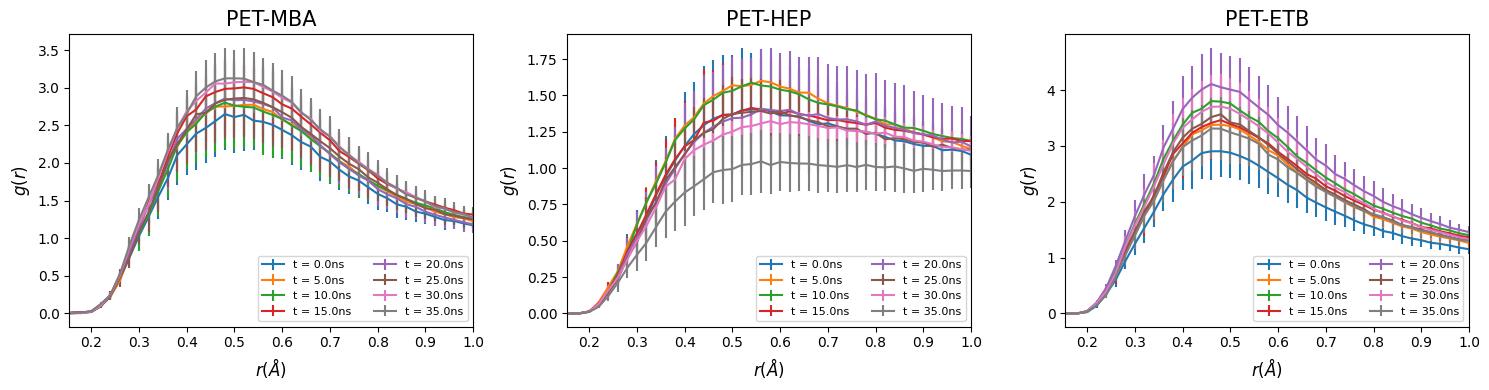

In [4]:
sz = 4
ar = 1.25

avg_in = avg_data[:, :3, :]
std_in = std_dev[:, :3, :]

fig, axs = plt.subplots(1, 3, figsize = (sz*ar*3, sz))
axs = axs.flatten()

xmax = 1.0
xmin = 0.154

for j in range(3):
    ax = axs[j]
    for i in range(8):
        ax.errorbar(radii, avg_in[i, j, :], yerr=std_in[i, j, :], label = f"t = {times[i]/1000}ns")
    ax.legend(fontsize = 8, ncol = 2)
    ax.set_ylabel(r"$g(r)$", fontsize = 12)
    ax.set_xlabel(r"$r (\AA)$", fontsize = 12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_title(f"PET-{labels[j + 3]}", fontsize = 15)
    ax.set_xlim([xmin, xmax])
    ax.tick_params(axis='both', which='minor', labelsize=8)

fig.tight_layout()
fig.savefig("hyd_mal-pet_time-series.svg")
fig.savefig("hyd_mal-pet_time-series.png", dpi = 300)

### NON-SOL SPECIES to SOL comparison

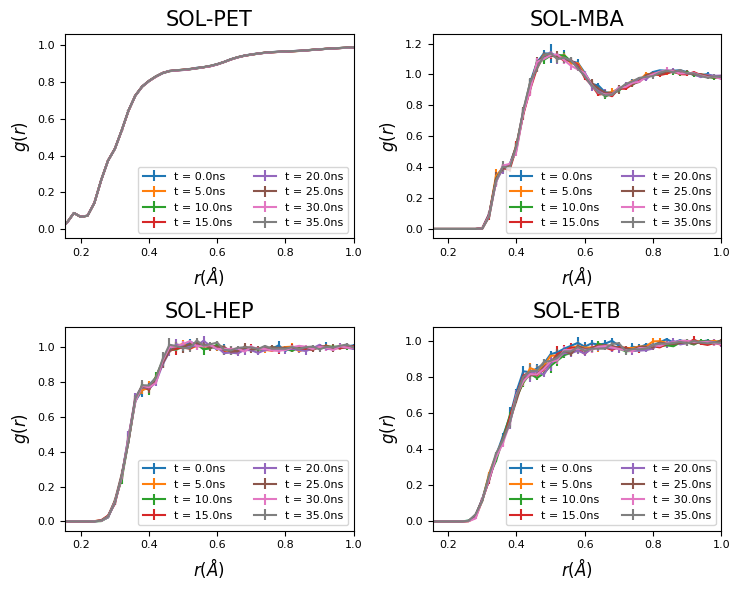

In [5]:
sz = 3
ar = 1.25

avg_in = avg_data[:, 3:, :]
std_in = std_dev[:, 3:, :]

fig, axs = plt.subplots(2, 2, figsize = (sz*ar*2, sz*2))
axs = axs.flatten()

for j in range(4):
    ax = axs[j]
    for i in range(8):
        ax.errorbar(radii, avg_in[i, j, :], yerr=std_in[i, j, :], label = f"t = {times[i]/1000}ns")
    ax.legend(fontsize = 8, ncol = 2)
    ax.set_ylabel(r"$g(r)$", fontsize = 12)
    ax.set_xlabel(r"$r (\AA)$", fontsize = 12)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_title(f"SOL-{labels[j + 2]}", fontsize = 15)
    ax.set_xlim([xmin, xmax])
    # ax.tick_params(axis='both', which='minor', labelsize=8)

fig.tight_layout()
fig.savefig("hyd_sol-nonsol_time-series.svg")
fig.savefig("hyd_sol-nonsol_time-series.png", dpi = 300)

### Average RDF's

[0.5]
[0.56 0.62 0.78 0.82 0.9  0.96 1.14 1.26 1.34 1.44 1.48]
[0.48]


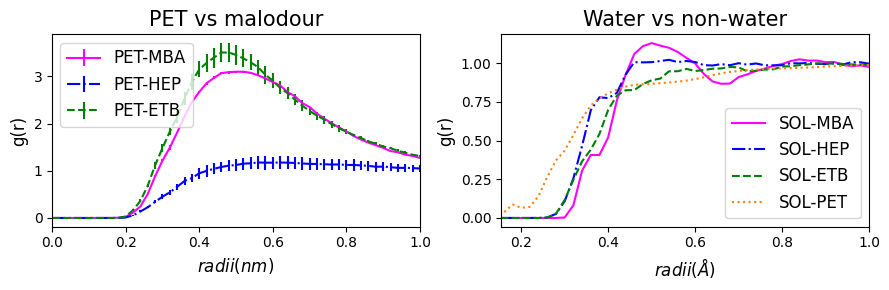

In [6]:
avg_all = np.mean(avg_data[time_slc, :, :], axis = 0)
std_all = np.std(avg_data[time_slc, :, :], axis = 0)

sz = 6
ar = 1.5

fig, axs = plt.subplots(1, 2, figsize = (sz*ar, sz/2))

ax = axs[0]

idx = 0
y = avg_all[idx]
yerr = std_all[idx]
ax.errorbar(radii, y, yerr = yerr, label = "PET-MBA", color = colors[idx], linestyle = linestyles[idx])
idxs = find_peaks(y)[0]
print(radii[idxs][np.where(radii[idxs] >= xmin)])

idx += 1
y = avg_all[idx]
yerr = std_all[idx]
ax.errorbar(radii, y, yerr = yerr, label = "PET-HEP", color = colors[idx], linestyle = linestyles[idx])
idxs = find_peaks(y)[0]
print(radii[idxs][np.where(radii[idxs] >= xmin)])

idx += 1
y = avg_all[idx]
yerr = std_all[idx]
ax.errorbar(radii, y, yerr = yerr, label = "PET-ETB", color = colors[idx], linestyle = linestyles[idx])
idxs = find_peaks(y)[0]
print(radii[idxs][np.where(radii[idxs] >= xmin)])

ax.set_xlabel(r"$radii(nm)$", fontsize = 12)
ax.set_ylabel(r"g(r)", fontsize = 12)
ax.legend(fontsize = 12)
ax.set_title("PET vs malodour", fontsize = 15)
ax.set_xlim([xmin_all, xmax_all])

ax = axs[1]
ax.plot(radii, avg_all[4], label = "SOL-MBA", color = colors[0], linestyle = linestyles[0])
ax.plot(radii, avg_all[5], label = "SOL-HEP", color = colors[1], linestyle = linestyles[1])
ax.plot(radii, avg_all[6], label = "SOL-ETB", color = colors[2], linestyle = linestyles[2])
ax.plot(radii, avg_all[3], label = "SOL-PET", color = colors[3], linestyle = linestyles[3])

ax.set_xlabel(r"$radii(\AA)$", fontsize = 12)
ax.set_ylabel(r"g(r)", fontsize = 12)
ax.legend(fontsize = 12)
ax.set_title("Water vs non-water", fontsize = 15)
ax.set_xlim([xmin, xmax])

fig.tight_layout()
fig.savefig("hyd_rdf.svg")
fig.savefig("hyd_rdf.png", dpi = 300)

## MSD Scaling

In [7]:
# data = np.zeros()

data = np.loadtxt("hydrated/run1/msd.xvg", comments=['@', '#'])

PET_ID = 2
MBA_ID = 3
HEP_ID = 4
ETB_ID = 5
SOL_ID = 6

times = np.arange(0, 40000, 5000)
labels = ["void", "radii", "PET", "MBA", "HEP", "ETB", "SOL"]

data_run = np.zeros((3, *data.shape))

for i, path1 in enumerate(hydrated_paths):
    data_run[i] = np.loadtxt(path1 + "/msd.xvg", comments=['@', '#'])

avg_data = np.average(data_run, axis = 0)
std_dev = np.std(data_run, axis = 0)

lag_time = avg_data[:, 0]

/tmp/ipykernel_36268/2888445720.py:11: RuntimeWarning: divide by zero encountered in log10
  idxs = np.isfinite(np.log10(x))


PET: 0.526
MBA: 0.891
HEP: 0.912
ETB: 0.863
SOL: 0.987


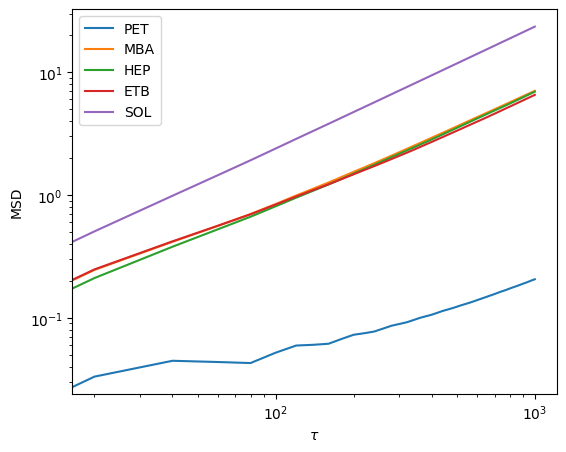

In [8]:
sz = 5
ar = 1.25

fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

for i in range(len(labels[1:-1])):
    x = lag_time
    y = avg_data[:, i + 1]
    ax.plot(x, y, label = f"{labels[i + 2]}")

    idxs = np.isfinite(np.log10(x))
    x = np.log10(x[idxs])
    y = np.log10(y[idxs])

    my_pwlf = pwlf.PiecewiseLinFit(x, y)
    res = my_pwlf.fit(1)
    
    print(f"{labels[i + 2]}: {my_pwlf.slopes[0]:.3f}")

    pwlf

ax.set_xlabel(r"$\tau$")
ax.set_ylabel("MSD")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

fig.savefig("hyd_msd.svg")
fig.savefig("hyd_msd.png", dpi = 300)

## Binding energy

In [9]:
# lie_mal = MAL - PET
# lie_sol = SOL - PET
# lie_pet = MAL - SOL

data = np.loadtxt("hydrated/run1/lie_mal_ETB.xvg", comments=['@', '#'])

all_data = np.zeros((len(malodour_molecules), len(hydrated_paths), 3, data.shape[0]))

for i, mal in enumerate(malodour_molecules):
    for j, path1 in enumerate(hydrated_paths):
        data = np.loadtxt(f"{path1}/lie_mal_{mal}.xvg", comments=['@', '#'])
        all_data[i, j, 0] = data[:, -1]
        data = np.loadtxt(f"{path1}/lie_sol_{mal}.xvg", comments=['@', '#'])
        all_data[i, j, 1] = data[:, -1]
        data = np.loadtxt(f"{path1}/lie_pet_{mal}.xvg", comments=['@', '#'])
        all_data[i, j, 2] = data[:, -1]

time = data[:, 0]/1000

all_data = np.where(all_data == 0, np.NaN, all_data)
avg_data = np.average(all_data, axis = 1)
std_data = np.std(all_data, axis = 1)

PET-MBA: 3868.930 pm 6.458$
PET-HEP: 8080.700 pm 36.668$
PET-ETB: 1326.943 pm 15.329$
PET-SOL: 676.883 pm 81.535$
PET-SOL: 4234.457 pm 81.533$
PET-SOL: -2289.627 pm 81.535$
SOL-MBA: -629.662 pm 81.534$
SOL-HEP: -629.662 pm 81.534$
SOL-ETB: -629.662 pm 81.534$


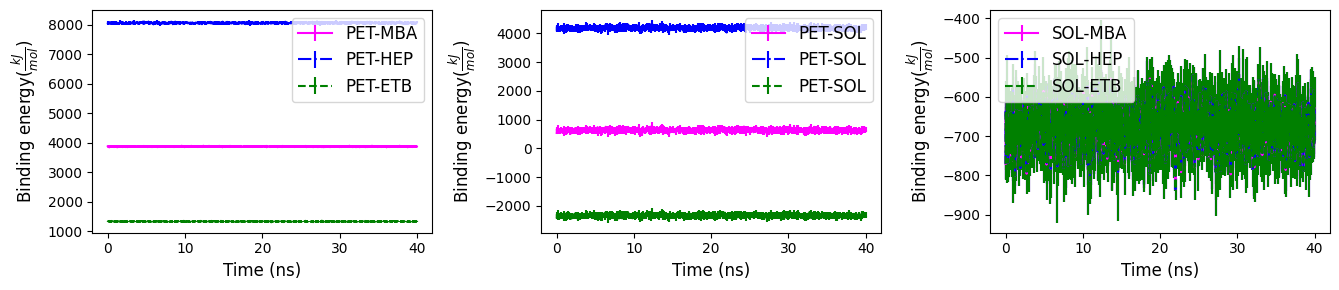

In [10]:
sz = 9
ar = 1.5

fig, axs = plt.subplots(1, 3, figsize = (sz*ar, sz/3))

ylabel = ["Number of clusters", "Maximum cluster size", "Average cluster size"]
titles = ["MAL-PET", "PET-SOL", "MAL-SOL"]

labels = [["PET-MBA", "PET-HEP", "PET-ETB"], ["PET-SOL"]*3, ["SOL-MBA", "SOL-HEP", "SOL-ETB"]]

for i in range(len(malodour_molecules)):
    ax = axs[i]
    for j in range(3):
        x = time
        y = avg_data[j, i]
        yerr = std_data[j, i]
        print(f"{labels[i][j]}: {y[-1]:.3f} pm {yerr[-1]:.3f}$")
        ax.errorbar(x, y, yerr = yerr, color = colors[j], linestyle = linestyles[j], label = labels[i][j])
    
    ax.legend(fontsize = 12)
    ax.set_xlabel("Time (ns)", fontsize = 12)
    ax.set_ylabel(r"Binding energy($\frac{kJ}{mol}$)", fontsize = 12)

fig.tight_layout()
# fig.savefig("hyd_binding-energy.svg")
# fig.savefig("hyd_binding-energy.png", dpi = 300)

# Anhydrous system

In [11]:
anhydrous_paths = sorted(glob.glob("anhydrous/run*"))

PET_ID = 2
MBA_ID = 3
HEP_ID = 4
ETB_ID = 5

times = np.arange(0, 40000, 5000)
labels = ["void", "radii", "PET", "MBA", "HEP", "ETB"]

## RDF

In [12]:
# Pairs of interest 
# 2 - 3
# 2 - 4
# 2 - 5
# 2 - 6
# 3 - 6
# 4 - 6
# 5 - 6

max_id = 91
slc = slice(0, max_id)

data_run = np.zeros((len(anhydrous_paths), 9, 3, max_id))

for i, path1 in enumerate(anhydrous_paths):
    PET_runs = sorted(glob.glob(path1 + "/rdf_PET*"))
    MBA_runs = sorted(glob.glob(path1 + "/rdf_MBA*"))
    HEP_runs = sorted(glob.glob(path1 + "/rdf_HEP*"))
    ETB_runs = sorted(glob.glob(path1 + "/rdf_ETB*"))

    for j in range(len(PET_runs)):
        path2 = PET_runs[j]
        data = np.loadtxt(path2, comments=['@', '#'])
        # MALODOUR TO PET
        data_run[i, j, 0, :] = data[slc, MBA_ID - 1].copy()
        data_run[i, j, 1, :] = data[slc, HEP_ID - 1].copy()
        data_run[i, j, 2, :] = data[slc, ETB_ID - 1].copy()

radii = data[slc, 0]

avg_data = np.average(data_run, axis = 0)
std_dev = np.std(data_run, axis = 0)

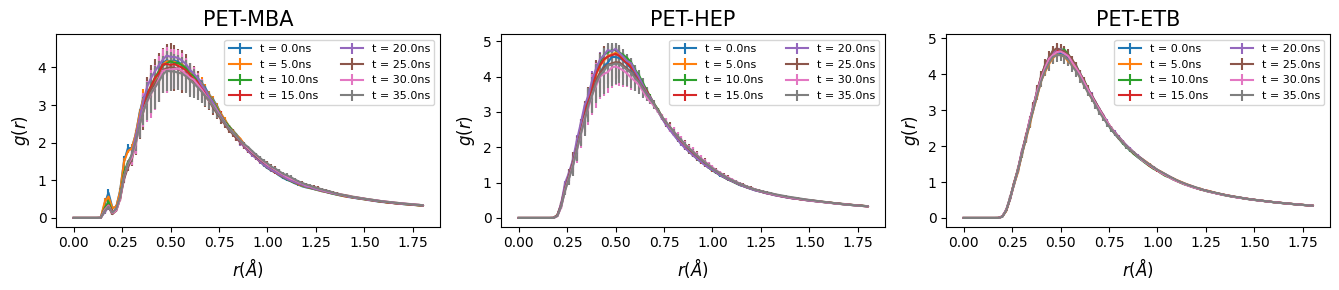

In [13]:
sz = 9
ar = 1.5

avg_in = avg_data[:, :3, :]
std_in = std_dev[:, :3, :]

fig, axs = plt.subplots(1, 3, figsize = (sz*ar, sz/3))
axs = axs.flatten()

for j in range(3):
    ax = axs[j]
    for i in range(8):
        ax.errorbar(radii, avg_in[i, j, :], yerr=std_in[i, j, :], label = f"t = {times[i]/1000}ns")
    ax.legend(fontsize = 8, ncol = 2)
    ax.set_ylabel(r"$g(r)$", fontsize = 12)
    ax.set_xlabel(r"$r (\AA)$", fontsize = 12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_title(f"PET-{labels[j + 3]}", fontsize = 15)
    ax.tick_params(axis='both', which='minor', labelsize=8)

fig.tight_layout()
fig.savefig("anhyd_mal-pet_time-series.svg")
fig.savefig("anhyd_mal-pet_time-series.png", dpi = 300)

[0.48 0.52]
[0.5]
[0.5]


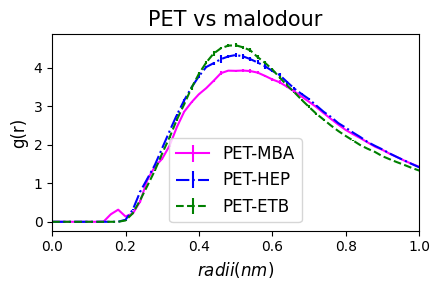

In [14]:
avg_all = np.mean(avg_data[time_slc, :, :], axis = 0)
std_all = np.std(avg_data[time_slc, :, :], axis = 0)

sz = 3
ar = 1.5

fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

xmin = 0.2

idx = 0
y = avg_all[idx]
yerr = std_all[idx]
ax.errorbar(radii, y, yerr = yerr, label = "PET-MBA", color = colors[idx], linestyle = linestyles[idx])
idxs = find_peaks(y)[0]
print(radii[idxs][np.where(radii[idxs] >= xmin)])

idx += 1
y = avg_all[idx]
yerr = std_all[idx]
ax.errorbar(radii, y, yerr = yerr, label = "PET-HEP", color = colors[idx], linestyle = linestyles[idx])
idxs = find_peaks(y)[0]
print(radii[idxs][np.where(radii[idxs] >= xmin)])

idx += 1
y = avg_all[idx]
yerr = std_all[idx]
ax.errorbar(radii, y, yerr = yerr, label = "PET-ETB", color = colors[idx], linestyle = linestyles[idx])
idxs = find_peaks(y)[0]
print(radii[idxs][np.where(radii[idxs] >= xmin)])

ax.set_xlim([xmin_all, xmax_all])
# ax.set_ylim([0, 90])
ax.set_xlabel(r"$radii(nm)$", fontsize = 12)
ax.set_ylabel(r"g(r)", fontsize = 12)
ax.legend(fontsize = 12)
ax.set_title("PET vs malodour", fontsize = 15)

fig.tight_layout()
fig.savefig("anhyd_rdf.svg")
fig.savefig("anhyd_rdf.png", dpi = 300)

## MSD

In [15]:
# data = np.zeros()

data = np.loadtxt("anhydrous/run1/msd.xvg", comments=['@', '#'])

PET_ID = 2
MBA_ID = 3
HEP_ID = 4
ETB_ID = 5

times = np.arange(0, 40000, 5000)
labels = ["void", "radii", "PET", "MBA", "HEP", "ETB"]

data_run = np.zeros((3, *data.shape))

for i, path1 in enumerate(anhydrous_paths):
    data_run[i] = np.loadtxt(path1 + "/msd.xvg", comments=['@', '#'])

avg_data = np.average(data_run, axis = 0)
std_dev = np.std(data_run, axis = 0)

lag_time = avg_data[:, 0]

/tmp/ipykernel_36268/1898295701.py:11: RuntimeWarning: divide by zero encountered in log10
  idxs = np.isfinite(np.log10(x))


PET: 0.874
MBA: 0.942
HEP: 0.935
ETB: 0.960


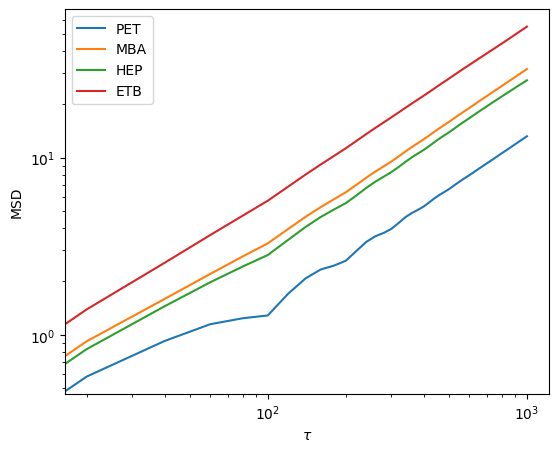

In [16]:
sz = 5
ar = 1.25

fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

for i in range(len(labels[1:-1])):
    x = lag_time
    y = avg_data[:, i + 1]
    ax.plot(x, y, label = f"{labels[i + 2]}")

    idxs = np.isfinite(np.log10(x))
    x = np.log10(x[idxs])
    y = np.log10(y[idxs])

    my_pwlf = pwlf.PiecewiseLinFit(x, y)
    res = my_pwlf.fit(1)
    
    print(f"{labels[i + 2]}: {my_pwlf.slopes[0]:.3f}")

    pwlf

ax.set_xlabel(r"$\tau$")
ax.set_ylabel("MSD")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

fig.savefig("anhyd_msd.svg")
fig.savefig("anhyd_msd.png", dpi = 300)